# YOLOV2 Scratch 

从零实现YOLOV2，用于复习和巩固。

In [1]:
import mxnet as mx
import numpy as np

from mxnet import nd
from mxnet import autograd
from mxnet import image
from mxnet import gluon
from mxnet.gluon.model_zoo import vision as model

%matplotlib inline
import matplotlib as mlt
mlt.rcParams['figure.dpi'] = 200
import matplotlib.pyplot as plt

## 中心点的转换

中心点是sigmoid函数的输出值，本身在0到1之间，表示的意义是每个格点内部的空间位置，我们需要把它们转换成图片上的相对位置，通过arange函数生成连续递增的数列，加上预测值，并除以图片格点的数量，就是每个目标中心在图片上的相对坐标。

In [2]:
def transform_center(xy):
    '''
    Given x, y prediction after sigmoid(), convert to relative coordinates (0,1) on image。
    '''
    b, h, w, n, s = xy.shape 
    
    offset_y = nd.tile(nd.arange(0, h, repeat=(w * n * 1), ctx=xy.context).reshape((1, h, w, n, 1)), (b, 1, 1, 1, 1))
    offset_x = nd.tile(nd.arange(0, w, repeat=(n * 1), ctx=xy.context).reshape((1, 1, w, n, 1)), (b, h, 1, 1, 1))
    
    # split x, y, || x, y is in (0, 1) after sigmoid  
    x, y = xy.split(num_outputs=2, axis=-1)

    x = (x + offset_x) / w
    y = (y + offset_y) / h
    
    return x, y

## 长宽的转换

长宽是exp函数的输出，意义是相对于锚点长宽的比率，我们对预测值的exp()乘以相对锚点的长宽，除以图片格点的数量，得到的是目标长宽相对于图片的尺寸。

In [3]:
def transform_size(wh, anchors):
    '''
    Given w, h prediction after exp() and anchor sizes, convert to relative width/height (0, 1) on image
    '''
    
    b, h, w, n, s = wh.shape
    
    aw, ah = nd.tile(nd.array(anchors, ctx=wh.context).reshape((1, 1, 1, -1, 2)), (b, h, w, 1, 1)).split(num_outputs=2, axis=-1)
    w_pred, h_pred = nd.exp(wh).split(num_outputs=2, axis=-1)
    
    w_out = w_pred * aw / w
    h_out = h_pred * ah / h
    
    return w_out, h_out

## YOLO V2的前向函数，用于生成预测值

yolov2_forward作为一个方便实用的函数，会把卷积的通道分开，转换，最后转成我们需要的检测框

In [4]:
def yolov2_forward(x, num_class, anchor_scales):
    '''Transpose/reshape/organize convolution outputs.'''
    stride = num_class + 1 + 4
    
    # transpose and reshape, 4th dim is the number of anchors, each anchor has stride property
    x = x.transpose((0, 2, 3, 1))
    x = x.reshape((0, 0, 0, -1, stride))
    # now x is (batch, m, n, stride), stride = num_class + 1(object_score) + 4(coordinates)
    
    # class probs 
    cls_pred = x.slice_axis(axis=-1, begin=0, end=num_class)
    
    # object score
    score_pred = x.slice_axis(axis=-1, begin=num_class, end=num_class + 1)
    score = nd.sigmoid(score_pred)
    
    # center prediction, in range(0, 1) for each grid
    xy_pred = x.slice_axis(axis=-1, begin=num_class + 1, end=num_class + 3)
    xy = nd.sigmoid(xy_pred)
    
    # width/height prediction
    wh = x.slice_axis(axis=-1, begin=num_class + 3, end=num_class + 5)
    
    # convert x, y to positions relative to image
    x, y = transform_center(xy)
    
    # convert w, h to width/height relative to image 
    w, h = transform_size(wh, anchor_scales)
    
    # cid is the argmax channel 
    cid = nd.argmax(cls_pred, axis=-1, keepdims=True)
    
    # convert to corner format boxes
    half_w = w / 2
    half_h = h / 2
    left = nd.clip(x - half_w, 0, 1)
    top = nd.clip(y - half_h, 0, 1)
    right = nd.clip(x + half_w, 0, 1)
    bottom = nd.clip(y + half_h, 0, 1)
    
    # the output shape is (b, h, w, n, 6)
    output = nd.concat(*[cid, score, left, top, right, bottom], dim=4)

    return output, cls_pred, score, nd.concat(*[xy, wh], dim=4)

## YOLO V2的目标函数，用于生成真实值

YOLOV2寻找真实目标的方法比较特殊，是在每个格点内各自比较，而不是使用全局的预设。而且我们不需要对生成的训练目标进行反向传播，为了简洁描述比较的方法，我们可以在这里转成numpy而且可以使用for循环（这么做的原因是转成numpy会破坏自动求导的记录，只有当反向传播不需要的时候才会使用这个技巧），在实际使用中，如果遇到速度问题，我们可以用mx.ndarray矩阵的写法来加速。

这里我们使用的另一个技巧是：<font color="red"><b>sample_weight（个体权重）矩阵，用于损失函数内部权重的调整，我们也可以通过权重矩阵来控制哪些个体需要被屏蔽，这一点在目标检测中尤其重要，因为往往大多数的背景区域不需要预测检测框。</b></font>

In [20]:
def yolov2_target(scores, labels, anchors, ignore_label=-1):
    '''Generate training targets given predictions and labels.'''
    
    b, h, w, n, _ = scores.shape # n represent the num of anchors 
    anchors = np.reshape(np.array(anchors), (-1, 2))
    
    gt_boxes = nd.slice_axis(labels, begin=1, end=5, axis=-1) # ground-truth boxes 
    
    target_score = nd.zeros((b, h, w, n, 1), ctx=scores.context)
    target_id = nd.ones_like(target_score, ctx=scores.context) * ignore_label
    target_box = nd.zeros((b, h, w, n, 4), ctx=scores.context)
    
    sample_weight = nd.zeros((b, h, w, n, 1), ctx=scores.context)
    
    for b in range(output.shape[0]):
        # find the best match for each ground-truth
        label = labels[b].asnumpy()
        valid_label = label[np.where(label[:, 0] > -0.5)[0], :] # select the label that label[:, 0] > -0.5
        # shuffle because multi gt could possibly match to one anchor, we keep the last match randomly
        np.random.shuffle(valid_label)
        for l in valid_label:
            gx, gy, gw, gh = (l[1] + l[3]) / 2, (l[2] + l[4]) / 2, l[3] - l[1], l[4] - l[2]
            ind_x = int(gx * w)
            ind_y = int(gy * h)
            tx = gx * w - ind_x
            ty = gy * h - ind_y
            gw = gw * w
            gh = gh * h
            
            # find the best match using width and height only, assuming centers are identical
            
            intersect = np.minimum(anchors[:, 0], gw) * np.minimum(anchors[:, 1], gh)
            ovps = intersect / (gw * gh + anchors[:, 0] * anchors[:, 1] - intersect)
            best_match = int(np.argmax(ovps))        
        
            target_id[b, ind_y, ind_x, best_match, :] = l[0]
            target_score[b, ind_y, ind_x, best_match, :] = 1.0
            
            tw = np.log(gw / anchors[best_match, 0])
            th = np.log(gh / anchors[best_match, 1])
            
            target_box[b, ind_y, ind_x, best_match, :] = nd.array([tx, ty, tw, th])
            sample_weight[b, ind_y, ind_x, best_match, :] = 1.0
            
    return target_id, target_score, target_box, sample_weight

## 定义YOLOV2输出层并构建主体网络

我们抽取预训练模型的特征提取层的权重，并自定义卷积输出层作为最终的输出层，因为YOLOV2是全卷积网络

In [6]:
class YOLOV2Output(gluon.nn.HybridBlock):
    def __init__(self, num_class, anchor_scales, **kwargs):
        super(YOLOV2Output, self).__init__(**kwargs)
        assert num_class > 0, "number of classes should > 0, given {}.".format(num_class)
        self._num_class = num_class
        assert isinstance(anchor_scales, (list, tuple)), "list or tuple of anchor scales required."
        assert len(anchor_scales) > 0, "at least one anchor scale required."
        for anchor in anchor_scales:
            assert len(anchor) == 2, "expected each anchor scale to be (width, height), provided {}.".format(anchor)
        self._anchor_scales = anchor_scales
        out_channels = len(anchor_scales) * (num_class + 1 + 4)
        with self.name_scope():
            self.output = gluon.nn.Conv2D(out_channels, 1, 1)
            
    def hybrid_forward(self, F, X):
        return self.output(X)

In [8]:
pretrained = model.get_model('resnet18_v1', pretrained=True).features
net = gluon.nn.HybridSequential()
for i in range(len(pretrained) - 2):
    net.add(pretrained[i])
    
# anchor scales, try adjust it yourself
scales = [[3.3004, 3.59034],
          [9.84923, 8.23783]]

# use 2 classes. 1 as dummy class, otherwise softmax won't work
predictor = YOLOV2Output(2, scales)
predictor.initialize()
net.add(predictor)

In [9]:
def yolov2_target2(scores, labels, anchors, ignore_label=-1):
    b, h, w, n, _ = scores.shape # n represent the number of targets 
    
    anchors = np.reshape(nd.array(anchors), (-1, 2))
    
    gt_boxes = nd.slice_axis(labels, begin=1, end=5, axis=-1)
    
    target_score = nd.zeros((b, h, w, n, 1), ctx=scores.context)
    target_id = nd.ones_like(target_score, ctx=scores.context)
    target_box = nd.zeros((b, h, w, n, 4), ctx=scores.context)
    sample_weight = nd.zeros((b, h, w, n, 1), ctx=scores.context)
    
    for b in range(output.shape[0]):
        # find the best match for each ground-truth
        label = labels[b].asnumpy()
        valid_label = label[np.where(label[:, 0] > -0.5)[0], :]
        # shuffle because multi gt could possibly match to one anchor, 
        # we keep the best match
        np.random.shuffle(valid_label)
        for l in valid_label:
            gx, gy, gw, gh = (l[1] + l[3]) / 2, (l[2] + l[4]) / 2, l[3] - l[1], l[4] - l[2]
            ind_x = int(gx * w)
            ind_y = int(gy * h)
            tx = gx * w - ind_x # offset x 
            ty = gy * h - ind_y # offset y
            gw = gw * w
            gh = gh * h
            
            # find the best match using width and height only, 
            # assuming centers are identical 
            intersect = np.minimum(anchors[:, 0], gw) * np.minimum(anchors[:, 1], gh)
            overlaps = intersect / (gw * gh + anchors[:, 0] * anchors[:, 1] - intersect)
            best_match = int(np.argmax(overlaps))
        
            target_id[b, ind_y, ind_x, best_match, :] = l[0]
            target_score[b, ind_y, ind_x, best_match, :] = 1.0
            tw = np.log(gw / anchors[best_match, 0])
            th = np.log(gh / anchors[best_match, 1])
            target_box[b, ind_y, ind_x, best_match, :] = nd.array([tx, ty, tw, th])
            sample_weight[b, ind_y, ind_x, best_match, :] = 1.0
            
    return target_id, target_score, target_box, sample_weight      

## 损失函数

损失函数包含两部分，类别损失函数和边框损失函数

In [10]:
sce_loss = gluon.loss.SoftmaxCrossEntropyLoss()
l1_loss = gluon.loss.L1Loss()

## 评估测量

这里我们取巧用一个自己定义的metric来记录纯损失值，有的时候你想不出特别贴切的观测函数，不如直接看损失值有没有下降

In [11]:
from mxnet import metric

class LossRecorder(mx.metric.EvalMetric):
    '''
    LossRecorder is used to record raw loss so we can observe loss directly
    '''
    
    def __init__(self, name):
        super(LossRecorder, self).__init__(name)
        
    def update(self, labels, preds=0):
        '''
        Update metric with pure Loss
        '''
        
        for loss in labels:
            if isinstance(loss, mx.nd.NDArray):
                loss = loss.asnumpy()
            self.sum_metric += loss.sum()
            self.num_inst += 1

obj_loss = LossRecorder('objectness_loss')
cls_loss = LossRecorder('classification_loss')
box_loss = LossRecorder('boxes_refine_loss')

# 粗粒度调控下每种损失相对的权重
positive_weight = 5.0
negative_weight = 0.1
class_weight = 1.0
box_weight = 5.0

## 下载并加载数据集

In [12]:
# download the dataset
from mxnet import gluon

root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
            'gluon/dataset/pikachu/')
data_dir = 'data/pikachu/'
dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}

for k, v in dataset.items():
    gluon.utils.download(root_url + k, data_dir + k, sha1_hash=v)

In [13]:
# load dataset
data_shape = 256
batch_size = 32

rgb_mean = nd.array([123, 117, 104])
rgb_std = nd.array([58.395, 57.12, 57.375])

def get_iterators(data_shape, batch_size):
    class_names = ['pikachu', 'dummy']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(batch_size=batch_size, data_shape=(3, data_shape, data_shape),
                                   path_imgrec=data_dir+'train.rec', path_imgidx=data_dir+'train.idx',
                                   shuffle=True, mean=True, std=True, rand_crop=1, min_object_covered=0.95,
                                   max_attempts=200)
    valid_iter = image.ImageDetIter(batch_size=batch_size, data_shape=(3, data_shape, data_shape),
                                   path_imgrec=data_dir+'val.rec', shuffle=False, mean=True, std=True)
    
    return train_iter, valid_iter, class_names, num_class
    
train_data, test_data, class_names, num_class = get_iterators(data_shape=data_shape, batch_size=batch_size)

In [14]:
# show some data
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]


In [15]:
# plot image
def box_to_rect(box, color, linewidth=1):
    '''convert an anchor box to a matplotlib rectangle'''
    box = box.asnumpy()
    return plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, 
                         edgecolor=color, linewidth=linewidth) # width, height

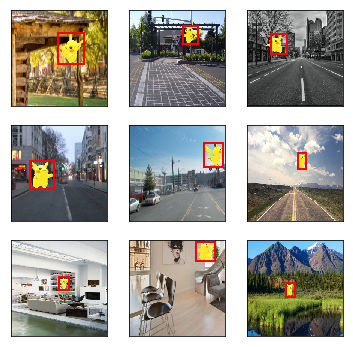

In [16]:
_, figs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]
        img = img.transpose((1, 2, 0)) * rgb_std + rgb_mean
        img = img.clip(0, 255).asnumpy() / 255
        fig = figs[i][j]
        fig.imshow(img)

        for label in labels:
            rect = box_to_rect(label[1:5] * data_shape, 'red', 2)
            fig.add_patch(rect)
            
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.show()

## 训练

In [46]:
ctx = mx.gpu(0)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

In [47]:
import time 

for epoch in range(100):
    # reset date iterations and metrics
    train_data.reset()
    cls_loss.reset()
    obj_loss.reset()
    box_loss.reset()
    tic = time.time()
    
    for i, batch in enumerate(train_data):
        x = batch.data[0].as_in_context(ctx)
        labels = batch.label[0].as_in_context(ctx)
        
        with autograd.record():
            x = net(x)        
            output, cls_pred, score, xywh = yolov2_forward(x, num_class=2, anchor_scales=scales)
            
            # when generate targets, we do not back propagate the gradient 
            with autograd.pause():
                tid, tscore, tbox, sample_weight = yolov2_target(score, labels, scales)
                
            # losses
            loss1 = sce_loss(cls_pred, tid, sample_weight * class_weight)
            score_weight = nd.where(sample_weight > 0, nd.ones_like(sample_weight) * positive_weight,
                                   nd.ones_like(sample_weight) * negative_weight)
            
            loss2 = l1_loss(score, tscore, score_weight)
            loss3 = l1_loss(xywh, tbox, sample_weight * box_weight)
            loss = loss1 + loss2 + loss3
        
        loss.backward()
        trainer.step(batch_size)
        
        # update metrics
        cls_loss.update(loss1)
        obj_loss.update(loss2)
        box_loss.update(loss3)
        
    print("Epoch %2d, train %s %.5f, %s, %.5f, %s %.5f, time %.1f sec" % (
        epoch, *cls_loss.get(), *obj_loss.get(), *box_loss.get(), time.time() - tic))

Epoch  0, train classification_loss 0.00004, objectness_loss, 0.00219, boxes_refine_loss 0.00122, time 8.2 sec
Epoch  1, train classification_loss 0.00003, objectness_loss, 0.00208, boxes_refine_loss 0.00118, time 8.1 sec
Epoch  2, train classification_loss 0.00004, objectness_loss, 0.00217, boxes_refine_loss 0.00117, time 7.9 sec
Epoch  3, train classification_loss 0.00004, objectness_loss, 0.00220, boxes_refine_loss 0.00121, time 7.8 sec
Epoch  4, train classification_loss 0.00003, objectness_loss, 0.00202, boxes_refine_loss 0.00117, time 7.9 sec
Epoch  5, train classification_loss 0.00004, objectness_loss, 0.00215, boxes_refine_loss 0.00119, time 8.0 sec
Epoch  6, train classification_loss 0.00003, objectness_loss, 0.00203, boxes_refine_loss 0.00113, time 8.2 sec
Epoch  7, train classification_loss 0.00003, objectness_loss, 0.00195, boxes_refine_loss 0.00113, time 8.2 sec
Epoch  8, train classification_loss 0.00002, objectness_loss, 0.00191, boxes_refine_loss 0.00114, time 8.1 sec
E

Epoch 74, train classification_loss 0.00002, objectness_loss, 0.00140, boxes_refine_loss 0.00084, time 7.7 sec
Epoch 75, train classification_loss 0.00003, objectness_loss, 0.00151, boxes_refine_loss 0.00086, time 7.8 sec
Epoch 76, train classification_loss 0.00002, objectness_loss, 0.00141, boxes_refine_loss 0.00084, time 7.7 sec
Epoch 77, train classification_loss 0.00002, objectness_loss, 0.00144, boxes_refine_loss 0.00084, time 7.8 sec
Epoch 78, train classification_loss 0.00003, objectness_loss, 0.00151, boxes_refine_loss 0.00086, time 7.7 sec
Epoch 79, train classification_loss 0.00002, objectness_loss, 0.00142, boxes_refine_loss 0.00081, time 8.5 sec
Epoch 80, train classification_loss 0.00002, objectness_loss, 0.00141, boxes_refine_loss 0.00083, time 8.1 sec
Epoch 81, train classification_loss 0.00002, objectness_loss, 0.00138, boxes_refine_loss 0.00082, time 7.7 sec
Epoch 82, train classification_loss 0.00002, objectness_loss, 0.00140, boxes_refine_loss 0.00081, time 7.8 sec
E

## 预测并显示结果

In [53]:
def process_image(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    # resize to data_shape
    data = image.imresize(im, data_shape, data_shape)
    # minus rgb mean, divide std
    data = (data.astype(np.float32) - rgb_mean) / rgb_std
    # convert to batch X channel X height X width
    return data.transpose((2,0,1)).expand_dims(axis=0), im

In [54]:
def predict(x):
    x = net(x)
    output, cls_prob, score, xywh = yolov2_forward(x, num_class=2, anchor_scales=scales)
    return nd.contrib.box_nms(output.reshape((0, -1, 6)))

In [55]:
x, im = process_image('pikachu.jpg')
out = predict(x.as_in_context(ctx))

In [56]:
out.shape

(1, 512, 6)

In [58]:
out


[[[ 0.          0.9990381   0.5238506   0.5109464   0.6643389
    0.6966678 ]
  [ 0.          0.9956449   0.22109337  0.59532344  0.35448456
    0.7258779 ]
  [ 0.          0.9690289   0.75526327  0.52791494  0.8967431
    0.6950919 ]
  ...
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]]]
<NDArray 1x512x6 @gpu(0)>

In [59]:
mlt.rcParams['figure.figsize'] = (8, 8)

colors = ['blue', 'green', 'red', 'black', 'magenta']

def display(im, out, threshold=0.5):
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]

        if class_id < 0 or score < threshold:
            continue
        print(score)
        color = colors[class_id % len(colors)]
        box = row[2:6] * np.array([im.shape[0], im.shape[1]] * 2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)
        
        text = class_names[class_id]
        plt.gca().text(box[0], box[1], '{:s} {:2f}'.format(text, score), 
                       bbox=dict(facecolor=color, alpha=0.5), fontsize=10, color="white")
        
    plt.show()

0.9990381
0.9956449
0.9690289
0.9469597
0.8668696
0.5784658


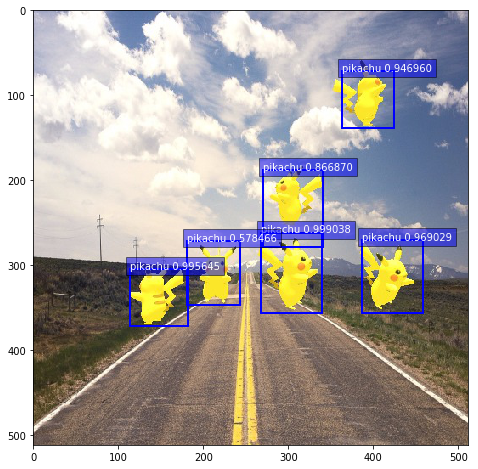

In [60]:
display(im, out[0], threshold=0.5)